# Introduction

Regarding the domain of Deep Learning in Computer Vision, one of the main challenge is to prepare huge datasets of properly labelled images for supervised learning. But labelling a huge amount of images must be performed by humans, and this is a costly task. A way to treat this problem is to pretrain a model with unsupervised learning, and then finetune the pretrained model for the final task we want it to perform. 

The objective of this notebook is to provide a minimalist implementation of a context prediction task, as described in [this paper](https://arxiv.org/pdf/1505.05192.pdf). 

All along this notebook we will use these 2 terms:

*Pretext task*: unsupervised learning of the model by context prediction

*Downstream task*: finetuning the pretrain model for the main task

For the purpose of a simple and easily comprehensible implementation, the dataset used is a Fruit dataset, containing images of 3 differents fruits.

The steps are the following:
1.   Global Datasets preparation
2.   Dataset preparation for the pretext task
3.   Model implementation/training for the pretext task
4.   Analyses of pretext tasks results
5.   Finetuning the model for the downstream task
6.   Results from prediction for the downstream task



# 1) Global Datasets preparation

## 1.1) Presentation of data used

First of all we import all the necessary libraries.

In [1]:
import pandas as pd
import os
from tqdm.notebook import tnrange,tqdm_notebook
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageNet
import numpy as np 
from google.colab.patches import cv2_imshow
import cv2 as cv
import imutils
from PIL import Image
import matplotlib.pyplot as plt

The dataset used in this notebook is named African Wildlife, and can be found on Kaggle [here](https://www.kaggle.com/biancaferreira/african-wildlife).

To continue following the notebook, you should download the dataset in your machine, upload it on a google drive, mount this google drive on this notebook and copy + unzip the dataset in the folder /content/ .



In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
!cp /gdrive/MyDrive/Datasets/AfricanWildlife.zip /content
!unzip /content/AfricanWildlife.zip
!rm -r /content/AfricanWildlife.zip

## 1.2) Preparation of the different datasets

In the dataset, there are 4 folders, 1 by animal. We construct 1 dataframe by animal, in which we keep only the pictures with width and height higher than 300 pixels and we count how many pictures are left for each animal.

In [ ]:
def create_dataframe(animal):
  jpg = [('/content/'+animal+'/'+path) for path in list(sorted(os.listdir('/content/'+animal))) if '.jpg' in str.lower(path)]
  txt = [('/content/'+animal+'/'+path) for path in list(sorted(os.listdir('/content/'+animal))) if '.txt' in str.lower(path)]
  width = [cv.imread(('/content/'+animal+'/'+image)).shape[1] for image in list(sorted(os.listdir('/content/'+animal))) if '.jpg' in str.lower(image)]
  heigth = [cv.imread(('/content/'+animal+'/'+image)).shape[0] for image in list(sorted(os.listdir('/content/'+animal))) if '.jpg' in str.lower(image)]
  return pd.DataFrame({'images': jpg, 'annotations': txt, 'widths': width, 'heights': heigth})

In [ ]:
elephants = create_dataframe('elephant')
elephants = elephants[(elephants['widths']>=300) & (elephants['heights']>=300)]
rhinos = create_dataframe('rhino')
rhinos = rhinos[(rhinos['widths']>=300) & (rhinos['heights']>=300)]
buffalos = create_dataframe('buffalo')
buffalos = buffalos[(buffalos['widths']>=300) & (buffalos['heights']>=300)]
zebras = create_dataframe('zebra')
zebras = zebras[(zebras['widths']>=300) & (zebras['heights']>=300)]

In [ ]:
print('elephants:',elephants.shape[0],'| buffalos:',buffalos.shape[0], '| rhinos:', rhinos.shape[0], '| zebras:',zebras.shape[0])

elephants: 354 | buffalos: 294 | rhinos: 337 | zebras: 356


There are 294 images left for buffalos. We can then divide the dataset in 3 differents datasets:


*   *pretext_train*: dataset of 180 images by animal, for the unsupervised context training
*   *downstream_train*: 70 images by animal, trainset for the downstream task
*   *downstream_test*: the images left, testset for the downstream task



**Dataset (train/test) for the pretext task**

In [ ]:
pretext_train = pd.concat([elephants.iloc[0:140], rhinos.iloc[0:140], buffalos.iloc[0:140], zebras.iloc[0:140]])
pretext_train.shape

(560, 4)

In [ ]:
pretext_test = pd.concat([elephants.iloc[140:180], rhinos.iloc[140:180], buffalos.iloc[140:180], zebras.iloc[140:180]])
pretext_test.shape

(160, 4)

**Dataset for the downstream task training**

In [ ]:
downstream_train = pd.concat([elephants.iloc[180:250], rhinos.iloc[180:250], buffalos.iloc[180:250], zebras.iloc[180:250]])
downstream_train.shape

(280, 4)

**Dataset for the dowstream task test**

In [ ]:
downstream_test = pd.concat([elephants.iloc[250:294], rhinos.iloc[250:294], buffalos.iloc[250:], zebras.iloc[250:294]])
downstream_test.shape

(176, 4)

# 2) Dataset preparation for the pretext task

Here is a class containing all the global parameters

In [ ]:
class Parameters():
  patch_size = 70
  gap = 35
  jitter = 5
  batchs = 28

## 2.1) Extracting the patches from the image

For the pretext task, we extract 2 square patches from each image in the **pretext_train** dataset. The first patch is in the middle of a 9x9 patches grid and the 2nd patch is taken in random in one of the 8 positions around the first patch. 

**Function to extract the 2 patches from a given image**

Auxiliary function *find_label*

In [ ]:
def find_label(x,y):
  key = (x,y)
  table = {(0,0):0, (1,0):1, (2,0):2, (0,1):3, (2,1):4, (0,2):5, (1,2):6, (2,2):7}
  return table[key]

In [ ]:
def create_patches(image):
  (h,w,d) = image.shape
  # compute the max possible value for topleft of the 1st patch
  max_w = w - 3*Parameters.patch_size - 2*Parameters.gap - 3*Parameters.jitter
  max_h = h - 3*Parameters.patch_size - 2*Parameters.gap - 3*Parameters.jitter
  start_w = np.random.randint(max_w)
  start_h = np.random.randint(max_h)

  # compute the box coordinates for 1st patch
  patch1 = [(start_w + Parameters.patch_size + Parameters.gap,
            start_h + Parameters.patch_size + Parameters.gap),
            (start_w + 2*Parameters.patch_size + Parameters.gap,
            start_h + 2*Parameters.patch_size + Parameters.gap)]

  # take at random position for the second patch
  n_w = np.random.randint(3); n_h = np.random.randint(3)
  # need a correction if equal to 1st patch
  if n_w==1 and n_h==1:
    n_w=0
  # Find the label
  label = find_label(n_w, n_h)

  # compute the box coordinates for the 2nd patch
  patch2 = [(start_w + n_w*Parameters.patch_size + n_w*Parameters.gap,
            start_h + n_h*Parameters.patch_size + n_h*Parameters.gap),
            (start_w + (n_w+1)*Parameters.patch_size + n_w*Parameters.gap,
            start_h + (n_h+1)*Parameters.patch_size + n_h*Parameters.gap)]

  return patch1, patch2, label

**Demo of the function, taking an image in random in *pretext_train* dataset and showing the 2 patches extracted.**

In [ ]:
def patches_extraction_demo(df):
  index = np.random.randint(pretext_train.shape[0])
  image = cv.imread(pretext_train['images'].iloc[index])
  (h,w,d) = image.shape
  if (h>=w):
    image=imutils.resize(image,300)
  else:
    image=imutils.resize(image,int(301*w/h))
  patch1, patch2, label = create_patches(image)
  output = image.copy()
  cv.rectangle(output, patch1[0], patch1[1], (0, 0, 255), 2)
  cv.rectangle(output, patch2[0], patch2[1], (0, 0, 255), 2)
  cv2_imshow(output)
  patch1_im = image[patch1[0][1]:patch1[1][1], patch1[0][0]:patch1[1][0]]
  patch2_im = image[patch2[0][1]:patch2[1][1], patch2[0][0]:patch2[1][0]]
  print('patch1:')
  cv2_imshow(patch1_im)
  print('patch2:')
  cv2_imshow(patch2_im)
  print('\n---> Label:',label)

We can see how the function works by running this cell several times.

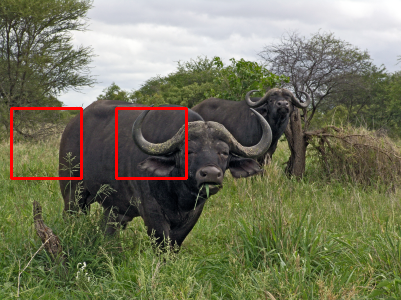

patch1:


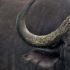

patch2:


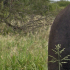


---> Label: 3


In [ ]:
patches_extraction_demo(pretext_train)

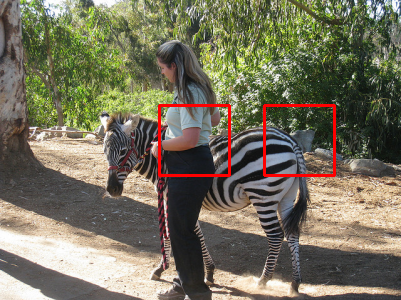

patch1:


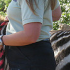

patch2:


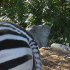


---> Label: 4


In [ ]:
index = np.random.randint(pretext_train.shape[0])
image = cv.imread(pretext_train['images'].iloc[index])
(h,w,d) = image.shape
if (h>=w):
  image=imutils.resize(image,300)
else:
  image=imutils.resize(image,int(301*w/h))
patch1, patch2, label = create_patches(image)
output = image.copy()
cv.rectangle(output, patch1[0], patch1[1], (0, 0, 255), 2)
cv.rectangle(output, patch2[0], patch2[1], (0, 0, 255), 2)
cv2_imshow(output)
patch1_im = image[patch1[0][1]:patch1[1][1], patch1[0][0]:patch1[1][0]]
patch2_im = image[patch2[0][1]:patch2[1][1], patch2[0][0]:patch2[1][0]]
print('patch1:')
cv2_imshow(patch1_im)
print('patch2:')
cv2_imshow(patch2_im)
print('\n---> Label:',label)

{'boxes': [<matplotlib.lines.Line2D at 0x7f15fec10850>],
 'caps': [<matplotlib.lines.Line2D at 0x7f15fec1a950>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f15fec7de10>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f15fec21450>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f15fec10e90>,
  <matplotlib.lines.Line2D at 0x7f15fec1a410>]}

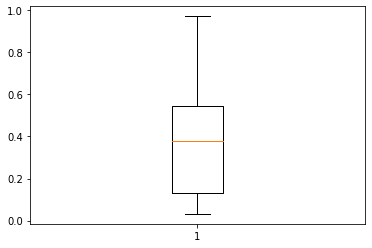

In [ ]:
out = transforms.ToTensor()(patch1_im)
out = out.flatten()
out.shape
test = out.numpy()
plt.boxplot(test)

In [ ]:
plt.imshow(out.permute(1,2,0))

## 2.2) Create the dataset and dataloaders for ConvNet input

In [ ]:
pretext_train.head(5)

,images,annotations,widths,heights
0,/content/elephant/001.jpg,/content/elephant/001.txt,591,640
1,/content/elephant/002.jpg,/content/elephant/002.txt,640,427
2,/content/elephant/003.jpg,/content/elephant/003.txt,640,360
3,/content/elephant/004.jpg,/content/elephant/004.txt,640,480
4,/content/elephant/005.jpg,/content/elephant/005.txt,640,335


**Define the main dataset**

In [ ]:
class PretextDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __getitem__(self, idx):
        # load image
        img = cv.imread(self.df['images'].iloc[idx])

        # resize the image to have 1 dimension = 300
        (h,w,d) = img.shape
        if (h>=w):
          img=imutils.resize(img,300)
        else:
          img=imutils.resize(img,int(301*w/h))

        # extract patches and label
        patch1, patch2, label = create_patches(img)
        patch1_im = img[patch1[0][1]:patch1[1][1], patch1[0][0]:patch1[1][0]]
        patch2_im = img[patch2[0][1]:patch2[1][1], patch2[0][0]:patch2[1][0]]

        ''' Dropped color channels 2 and 3 and replaced with gaussian noise(std ~1/100 of the std of the remaining channel)
        uniform_patch[:, :, 1] = np.random.normal(0.485, 0.01 * np.std(uniform_patch[:, :, 0]), (uniform_patch.shape[0],uniform_patch.shape[1]))
        uniform_patch[:, :, 2] = np.random.normal(0.485, 0.01 * np.std(uniform_patch[:, :, 0]), (uniform_patch.shape[0],uniform_patch.shape[1]))
        random_patch[:, :, 1] = np.random.normal(0.485, 0.01 * np.std(random_patch[:, :, 0]), (random_patch.shape[0],random_patch.shape[1]))
        random_patch[:, :, 2] = np.random.normal(0.485, 0.01 * np.std(random_patch[:, :, 0]), (random_patch.shape[0],random_patch.shape[1]))'''
        
        label = np.array(label).astype(np.int64)

        if self.transform:
          patch1_im = self.transform(patch1_im)
          patch2_im = self.transform(patch2_im)

        return patch1_im, patch2_im, label

    def __len__(self):
        return self.df.shape[0]

**Define the train and test datasets**

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor()])

dataset_train= PretextDataset(pretext_train, transform = transform)
dataset_test= PretextDataset(pretext_test, transform = transform)

**Define the train and test dataloaders**

In [ ]:
Traindata_loader = torch.utils.data.DataLoader(
    dataset_train, batch_size=Parameters.batchs, shuffle=True)

Testdata_loader = torch.utils.data.DataLoader(
    dataset_test batch_size=Parameters.batchs, shuffle=False)

**print next image from the train dataloader**

--> Label: 5


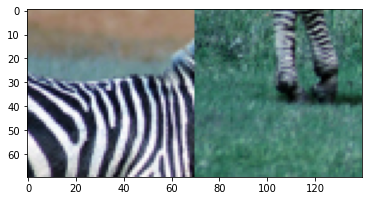

In [ ]:
image1, image2, label = next(iter(Traindata_loader))
image1 = image1[0]
image2 = image2[0]
label = label[0]
print('--> Label:', label.item())
concatenated = torch.cat((image1.permute(1,2,0),image2.permute(1,2,0)),1)
plt.imshow(torchvision.utils.make_grid(concatenated))

In [ ]:
image1.shape

torch.Size([3, 70, 70])

In [ ]:
image1.shape
img = image1.flatten().numpy()

**test convolution**

In [ ]:
image1, image2, label = next(iter(Traindata_loader))
image1.shape

torch.Size([28, 3, 70, 70])

In [ ]:
weights = torch.rand(70,3,11,11)
bias = torch.rand(70)
out = nn.functional.conv2d(image1, weights, bias)

# 3) Model implementation/training for the pretext task

## 3.1) Architecture of the model

Here is the architecture of the model proposed by the article, taking 2 branches running in parrallel for each of the 2 patches, and then the fully-connected layers 6 are concatenated and inputed in other fully-connected layers. 


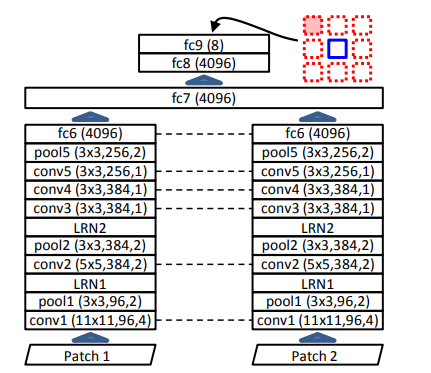

As we have the same patch size as in the article, we will keep the same dimensions for the layers.








In [ ]:
class AlexNet(nn.Module):
  def __init__(self,aux_logits = False):
      super(AlexNet, self).__init__()
      self.cnn = nn.Sequential(
        nn.Conv2d(3, 96, kernel_size=11, stride=4),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.LocalResponseNorm(96),
        #nn.ReLU(),
        #nn.BatchNorm2d(96),
        
        nn.Conv2d(96, 384, kernel_size=5, stride = 2,padding = 2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.LocalResponseNorm(384),
        #nn.ReLU(),
        #nn.BatchNorm2d(384),
        
        nn.Conv2d(384, 384, kernel_size=3, stride=1,padding = 1),
        nn.ReLU(inplace=True),
        #nn.ReLU(),
        nn.BatchNorm2d(384),
        
        nn.Conv2d(384, 384, kernel_size=3, stride=1,padding = 1),
        nn.ReLU(inplace=True),
        #nn.ReLU(),
        nn.BatchNorm2d(384),
        
        nn.Conv2d(384, 256, kernel_size=3, stride=1,padding = 1),
        nn.ReLU(inplace=True),
        #nn.ReLU(),
        nn.BatchNorm2d(256),
        nn.MaxPool2d(kernel_size=3, stride=2,padding = 1),
      )
      self.fc6 = nn.Sequential(
        nn.Linear(256,4096),
        nn.ReLU(inplace=True),
        #nn.ReLU(),
        nn.BatchNorm1d(4096),
      )
      self.fc = nn.Sequential(
        nn.Linear(2*4096,4096),
        nn.ReLU(inplace=True),
        #nn.ReLU(),

        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        #nn.ReLU(),

        nn.Linear(4096, 8)
      )

  def forward_once(self, x):
    output= self.cnn(x)
    output = output.view(output.size()[0], -1)
    output = self.fc6(output)
    return output

  def forward(self, patch1, patch2):
    output_fc6_patch1 = self.forward_once(patch1)
    output_fc6_patch2 = self.forward_once(patch2)
    output = torch.cat((output_fc6_patch1,output_fc6_patch2), 1)
    output = self.fc(output)
    return output, output_fc6_patch1, output_fc6_patch2

## 3.2) Instanciate the model and parameters

**Instanciate model and parameters**

In [ ]:
# model parameters
lr = 0.001
epochs = 300

# print the number of available GPUs
print('number of GPUs:',torch.cuda.device_count())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# instanciate the NN model and put it on GPU
net = AlexNet().to(device)

# optimizer / criterion / scheduler
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                           mode='min',
                                           patience=0,
                                           factor=0.3, verbose=True)

number of GPUs: 1
cuda:0


**Summary of the model**

In [ ]:
from torchsummary import summary
summary(net,[(3,70,70),(3,70,70)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 15, 15]          34,944
              ReLU-2           [-1, 96, 15, 15]               0
         MaxPool2d-3             [-1, 96, 7, 7]               0
 LocalResponseNorm-4             [-1, 96, 7, 7]               0
            Conv2d-5            [-1, 384, 4, 4]         921,984
              ReLU-6            [-1, 384, 4, 4]               0
         MaxPool2d-7            [-1, 384, 1, 1]               0
 LocalResponseNorm-8            [-1, 384, 1, 1]               0
            Conv2d-9            [-1, 384, 1, 1]       1,327,488
             ReLU-10            [-1, 384, 1, 1]               0
      BatchNorm2d-11            [-1, 384, 1, 1]             768
           Conv2d-12            [-1, 384, 1, 1]       1,327,488
             ReLU-13            [-1, 384, 1, 1]               0
      BatchNorm2d-14            [-1, 38

## 3.3) Unsupervised learning with pretext task

**Function to train over a batch**

In [ ]:
def train_batch(x1, x2, y, model, opt, criterion):
    model.train()
    prediction, out1, out2 = model(x1, x2)
    batch_loss = criterion(prediction, y)
    batch_loss.backward()
    optimizer.step()    
    optimizer.zero_grad()
    return batch_loss.item()

**Function to compute the loss over a batch**

In [ ]:
@torch.no_grad()
def val_loss(x1, x2, y, model):
    #model.eval()
    prediction, out1, out2 = model(x1, x2)
    val_loss = criterion(prediction, y)
    return val_loss.item()

**The training**

In [ ]:
train_losses = []
val_losses = []

for epoch in tqdm_notebook(range(epochs),total=epochs):
    train_epoch_losses, val_epoch_losses = [], []

    for ix, batch in tqdm_notebook(enumerate(Traindata_loader),total=int(len(Traindata_loader)),desc='train_error',leave=False):
        feature1, feature2, label = batch
        feature1 = feature1.to(device)
        feature2 = feature2.to(device)
        label = label.to(device)
        batch_loss = train_batch(feature1, feature2, label, net, optimizer, criterion)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in tqdm_notebook(enumerate(Testdata_loader),total=int(len(Traindata_loader)),desc='test_error',leave=False):
        feature1, feature2, label = batch
        feature1 = feature1.to(device)
        feature2 = feature2.to(device)
        label = label.to(device)
        validation_loss = val_loss(feature1, feature2, label, net)
        val_epoch_losses.append(validation_loss)
    val_epoch_loss = np.array(val_epoch_losses).mean()

    scheduler.step(val_epoch_loss)
    print('EPOCH',epoch,'-> Train Error:',train_epoch_loss,' | ','Test Error:',val_epoch_loss)

    train_losses.append(train_epoch_loss)
    val_losses.append(validation_loss)

EPOCH 0 -> Train Error: 2.8030464231967924  |  Test Error: 2.117305189371109


EPOCH 1 -> Train Error: 2.080093038082123  |  Test Error: 2.0530544459819793


EPOCH 2 -> Train Error: 2.050248163938522  |  Test Error: 2.0465005218982695


Epoch     4: reducing learning rate of group 0 to 3.0000e-04.
EPOCH 3 -> Train Error: 2.0495887875556944  |  Test Error: 2.050870084762573


EPOCH 4 -> Train Error: 2.0648179709911347  |  Test Error: 2.0388102293014527


EPOCH 5 -> Train Error: 2.0100089490413664  |  Test Error: 1.9926598131656648


Epoch     7: reducing learning rate of group 0 to 9.0000e-05.
EPOCH 6 -> Train Error: 2.0302809834480287  |  Test Error: 2.0247775673866273


Epoch     8: reducing learning rate of group 0 to 2.7000e-05.
EPOCH 7 -> Train Error: 2.02443123459816  |  Test Error: 2.0165270984172823


Epoch     9: reducing learning rate of group 0 to 8.1000e-06.
EPOCH 8 -> Train Error: 2.012065368890762  |  Test Error: 2.0072801649570464


Epoch    10: reducing learning rate of group 0 to 2.4300e-06.
EPOCH 9 -> Train Error: 2.0471694469451904  |  Test Error: 2.031758505105972


Epoch    11: reducing learning rate of group 0 to 7.2900e-07.
EPOCH 10 -> Train Error: 2.0237412452697754  |  Test Error: 2.0285510301589964


Epoch    12: reducing learning rate of group 0 to 2.1870e-07.
EPOCH 11 -> Train Error: 2.0096332848072054  |  Test Error: 2.008792978525162


Epoch    13: reducing learning rate of group 0 to 6.5610e-08.
EPOCH 12 -> Train Error: 1.9993687629699708  |  Test Error: 2.0035263657569886


Epoch    14: reducing learning rate of group 0 to 1.9683e-08.
EPOCH 13 -> Train Error: 2.0152145445346834  |  Test Error: 2.0271418154239655


Epoch    15: reducing learning rate of group 0 to 5.9049e-09.
EPOCH 14 -> Train Error: 2.0232463777065277  |  Test Error: 2.012985020875931


EPOCH 15 -> Train Error: 2.035497695207596  |  Test Error: 2.0383689224720003


EPOCH 16 -> Train Error: 2.008384829759598  |  Test Error: 2.0410270154476167


**Plot the errors**

In [ ]:
xaxis = [i for i in range(len(train_losses))]
plt.figure(figsize=(20,10))
plt.plot(xaxis,train_losses,label='train loss')
plt.plot(xaxis,val_losses,label='test loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')